# About activity_descriptors_detector.ipynb

This notebook detects different aspects of activities from log files.

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
from tabulate import tabulate
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 8,4

# Preparing activity descriptive data

## Getting log data

In [3]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file sperez8_beers_log_files_per_student.txt has been unpickled and loaded
The file sperez8_capacitor_log_files_per_student.txt has been unpickled and loaded


In [4]:
students = log_files_per_sim['beers'].keys()

## Two types of detectors

In [5]:
def detect_action(log_files_per_sim,students,initial_value,update_function,get_use_function,ignore_model_events=True):
    '''
    This function is a generic detector for a specific action.
    
    Args:
        students (list): All student to run detector on
        log_files_per_sim (dict): dictionary by sim and student of log file names
        initial_value (): False for binary usage, 0 for number of times students did something, etc...
        update_function (function): takes use from 1st log file and compares it to the next using max, sum, min, etc...
        get_use_function (function): takes a dataframe and returns what it detected

    Returns:
        action_use (dict): a dictionary by sim by student of use of action
    '''
    action_use = {'beers':{sid:initial_value for sid in students},'capacitor':{sid:initial_value for sid in students}}
    
    for sim in ['beers','capacitor']:
        for sid in students:
            logs = log_files_per_sim[sim][sid]
            use = initial_value

            for log in logs:
                df = prep_parsing_data(log,remove_model_events=ignore_model_events)
                if not df.empty:
                    use = update_function([use, get_use_function(df)])
            
            action_use[sim][sid] = use
    
    return action_use

In [6]:
def detect_multiple_actions(log_files_per_sim,students,detectors):
    '''
    This function is a generic actions detector.
    
    Args:
        students (list): All student to run detector on
        log_files_per_sim (dict): dictionary by sim and student of log file names
        detectors (list of tuples): Contains each detector:
            action (string): name of the action to use as column name in dataframe
            update_function (function): takes use from 1st log file and compares it to the next using max, sum, min, etc...
            get_use_function (function): takes a dataframe and returns what it detected

    Returns:
        df (DataFrame): a dataframe with sim*student rows and one column per action detected
    '''
    df_action_l = pd.DataFrame({'sid':students,'sim':'L'})
    df_action_c = pd.DataFrame({'sid':students,'sim':'C'})
    
    for sim,df_action in [('beers',df_action_l),('capacitor',df_action_c)]:
        action_use = {action:{sid:0 for sid in students} for action,_,_ in detectors}
        for sid in students:
            logs = log_files_per_sim[sim][sid]
            for log in logs:
                df = prep_parsing_data(log,remove_model_events=False)
                if not df.empty:
                    for action,update_function,get_use_function in detectors:
                        action_use[action][sid] = update_function([action_use[action][sid], get_use_function(df)])
    
        for action,_,_ in detectors:
            df_action[action] = df_action['sid'].map(action_use[action])
    return pd.concat([df_action_l,df_action_c])

## Actions to detect

### Activity duration and user actions

In [7]:
def get_activity_duration(df):
    return list(df.sort_values(by='Time')['Time'])[-1]

In [8]:
def get_number_actions(df):
    #ignore model events count dragging as 1 event (by only counting dragStarted)
    return df[(df['User or Model']!='model')&(df['Event']!='dragged')&(df['Event']!='dragEnded')].shape[0]

### Exploration measures

In [27]:
def get_time_second_record(df):
    times = list(df[df['Event']=='recording data']['Time'])
    if len(times)>=2:
        times.sort()
        return times[1] #return the time of the second record
    else:
        return list(df.sort_values(by='Time')['Time'])[-1] #else, return last time stamp

def get_time_first_record(df):
    times = list(df[df['Event']=='recording data']['Time'])
    if len(times)>=1:
        times.sort()
        return times[0] #return the time of the first record
    else:
        return list(df.sort_values(by='Time')['Time'])[-1] #else, return last time stamp

### Uses of different components

In [10]:
def get_use_concentration_plus_minus(df):
    if 'solutionControls slider' in df['Item'].tolist():
        return 1
    else:
        return 0

In [11]:
# #FIX ME
# def get_number_words_notes(df):
# #     print df.head()
#     return max([len(str(text).split(' ')) if str(text)=='nan' else 0 for text in df['Notes'].tolist()])

In [12]:
def get_use_move_trial(df):
    if 'Moving trial in table' in df['Event'].tolist():
        return 1
    else:
        return 0

In [13]:
def get_use_remove_trial(df):
    if 'Removing data from table' in df['Event'].tolist():
        return 1
    else:
        return 0

In [14]:
def get_use_restore(df):
    if 'Restoring sim state from trial' in df['Event'].tolist():
        return 1
    else:
        return 0

### Uses of variable controls

In [15]:
def get_use_number_area(df):
    if 'plateAreaDragHandleNode' in df['Item'].tolist():
        return df[df['Event']=='dragStarted']['Item'].value_counts()['plateAreaDragHandleNode']
    else:
        return 0

def get_use_number_separation(df):
    if 'plateSeparationDragHandleNode' in df['Item'].tolist():
        return df[df['Event']=='dragStarted']['Item'].value_counts()['plateSeparationDragHandleNode']
    else:
        return 0
    
def get_use_number_width(df):
    if 'cuvetteNode' in df['Item'].tolist():
        return df[df['Event']=='dragStarted']['Item'].value_counts()['cuvetteNode']
    else:
        return 0

def get_use_number_concentration(df):
    if 'Changed concentration' in df['Event'].tolist():
        number_plus_minus = df['Event'].value_counts()['Changed concentration']
    else:
        number_plus_minus = 0
    if 'solutionControls' in df['Item'].tolist():
        return df[df['Event']=='dragStarted']['Item'].value_counts()['solutionControls'] + number_plus_minus
    else:
        return number_plus_minus

def get_use_number_concentration_drag_only(df):
    if 'solutionControls' in df['Item'].tolist():
        return df[df['Event']=='dragStarted']['Item'].value_counts()['solutionControls']
    else:
        return 0

## Running detectors

In [28]:
detectors = [('duration',sum,get_activity_duration),
             ('number of actions',sum,get_number_actions),
             ('time second record',sum,get_time_second_record),
             ('time first record',sum,get_time_first_record),
             ('use concentration buttons',max,get_use_concentration_plus_minus),
             ('use restore',max,get_use_restore),
             ('use remove trial',max,get_use_remove_trial),
             ('use move trial',max,get_use_move_trial),
             ('use concentration',sum,get_use_number_concentration),
             ('use concentration drag only',sum,get_use_number_concentration_drag_only),
             ('use width',sum,get_use_number_width),
             ('use area',sum,get_use_number_area),
             ('use separation',sum,get_use_number_separation)
#              ('number of words in notes',max,get_number_words_notes),
            ]

In [29]:
# #test 1 student
detect_multiple_actions(log_files_per_sim,[10866146],detectors)

,sid,sim,duration,number of actions,time second record,time first record,use concentration buttons,use restore,use remove trial,use move trial,use concentration,use concentration drag only,use width,use area,use separation
0,10866146,L,1045.064,263,796.405,762.031,1,1,1,0,78,20,19,0,0
0,10866146,C,851.686,50,851.686,851.686,0,0,0,0,0,0,0,8,18


In [30]:
df = detect_multiple_actions(log_files_per_sim,students,detectors)
df['order'] = df['sid'].map(get_student_metadata()['activity order'].to_dict()) # add order of activity (CL or LC)
df['activity number'] = df.apply(lambda row: 1 if (row['sim']=='L' and row['order']=='LC') or (row['sim']=='C' and row['order']=='CL') else 2, axis=1)

# Investigation

## Use of components

In [19]:
df.groupby('activity number').describe()

duration  number of actions           sid  \
activity number                                                       
1               count   148.000000         148.000000  1.480000e+02   
                mean    830.706196         204.858108  2.204070e+07   
                std     163.668612         219.196244  1.807852e+07   
                min     165.834000          25.000000  1.012716e+07   
                25%     760.934500          78.750000  1.353541e+07   
                50%     879.096500         127.000000  1.670466e+07   
                75%     934.947750         226.250000  1.936215e+07   
                max    1064.577000        1419.000000  9.044717e+07   
2               count   148.000000         148.000000  1.480000e+02   
                mean    772.721926         170.547297  2.204070e+07   
                std     213.812654         136.361731  1.807852e+07   
                min     116.421000          22.000000  1.012716e+07   
                25%     638.995250          72.500000  1.353541e+07   
                50%     850.086500         130.500000  1.670466e+07   
                75%     918.471250         228.000000  1.936215e+07   
                max    1628.382000         799.000000  9.044717e+07   

                       time second record    use area  use concentration  \
activity number                                                            
1               count          148.000000  148.000000         148.000000   
                mean           307.919142    4.858108          17.459459   
                std            265.925811    6.293296          41.804758   
                min             19.455000    0.000000           0.000000   
                25%             93.133750    0.000000           0.000000   
                50%            207.591500    0.000000           1.500000   
                75%            469.546750    9.000000          14.000000   
                max            972.075000   27.000000         289.000000   
2               count          148.000000  148.000000         148.000000   
                mean           220.089372    5.797297          14.837838   
                std            226.923985    7.565550          38.319646   
                min             16.825000    0.000000           0.000000   
                25%             51.221750    0.000000           0.000000   
                50%            122.228000    2.000000           0.000000   
                75%            340.832500   10.000000          13.000000   
                max            945.799000   39.000000         244.000000   

                       use concentration buttons  use concentration drag only  \
activity number                                                                 
1               count                 148.000000                   148.000000   
                mean                    0.263514                     5.385135   
                std                     0.442034                     6.986404   
                min                     0.000000                     0.000000   
                25%                     0.000000                     0.000000   
                50%                     0.000000                     1.500000   
                75%                     1.000000                    10.000000   
                max                     1.000000                    34.000000   
2               count                 148.000000                   148.000000   
                mean                    0.222973                     4.472973   
                std                     0.417654                     5.653782   
                min                     0.000000                     0.000000   
                25%                     0.000000                     0.000000   
                50%                     0.000000                     0.000000   
                75%                     0.000000                     8.000000   
 

Half the students use the concentration buttons (49%) thus it's important to not just consider the slider for changing concentration.

Few students restore or move trials (at most 17 and 18% in a sim).

Half the students remove a trial from the table

## How many actions do students do?

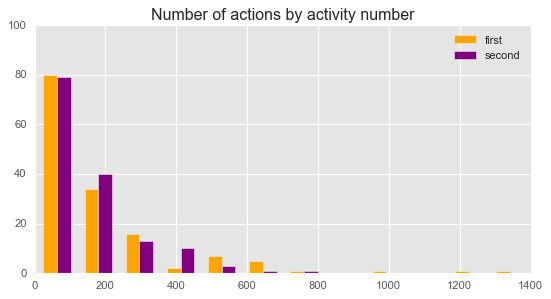

In [20]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df['activity number']==1]['number of actions'],bins=12)
b_heights, b_bins = np.histogram(df[df['activity number']==2]['number of actions'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='orange',label='first')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='purple',label='second')
plt.ylim(0,100)
plt.legend()
plt.title("Number of actions by activity number")
print

## How long are activities?

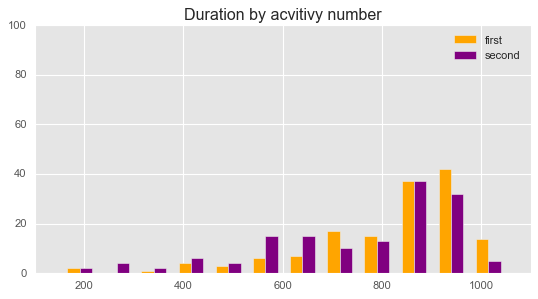

In [21]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df['activity number']==1]['duration'],bins=12)
b_heights, b_bins = np.histogram(df[df['activity number']==2]['duration'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='orange',label='first')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='purple',label='second')
plt.legend()
plt.ylim(0,100)
plt.title("Duration by acvitivy number")
print

## How long do students explore in each sim?

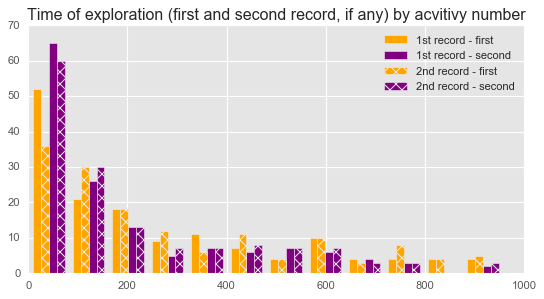

In [58]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df['activity number']==1]['time first record'],bins=12)
b_heights, b_bins = np.histogram(df[df['activity number']==2]['time first record'],bins=a_bins)
c_heights, c_bins = np.histogram(df[df['activity number']==1]['time second record'],bins=a_bins)
d_heights, d_bins = np.histogram(df[df['activity number']==2]['time second record'],bins=a_bins)

width = (a_bins[1] - a_bins[0])/5

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='orange',label='1st record - first')
ax.bar(b_bins[:-1]+width*2, b_heights, width=width, facecolor='purple',label='1st record - second')
ax.bar(c_bins[:-1]+width, c_heights, width=width, facecolor='orange',label='2nd record - first',alpha=1,hatch='XX')
ax.bar(d_bins[:-1]+width*3, d_heights, width=width, facecolor='purple',label='2nd record - second',alpha=1,hatch='XX')
plt.legend()
plt.title("Time of exploration (first and second record, if any) by acvitivy number")
print

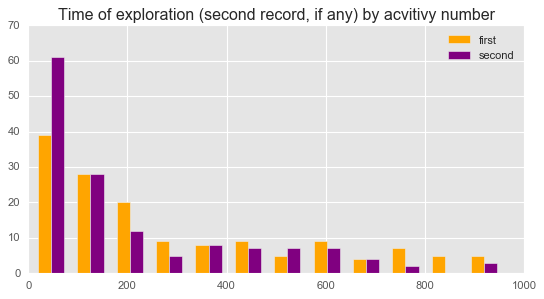

In [34]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(df[df['activity number']==1]['time second record'],bins=12)
b_heights, b_bins = np.histogram(df[df['activity number']==2]['time second record'],bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='orange',label='first')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='purple',label='second')
plt.legend()
plt.title("Time of exploration (second record, if any) by acvitivy number")
print

So far, we find that most students do less than 200 actions within an activity of over 800s (13.3 min) long and explore for the first 200s (3.3min). In the second activity, it seems like students do more actions in a shorter activity and explore much less.

The difference between looking at the 1st or 2nd record only changes things for the first activity: more students do their first record super early in the activity compared the second record.

## How many times do they change variable values?

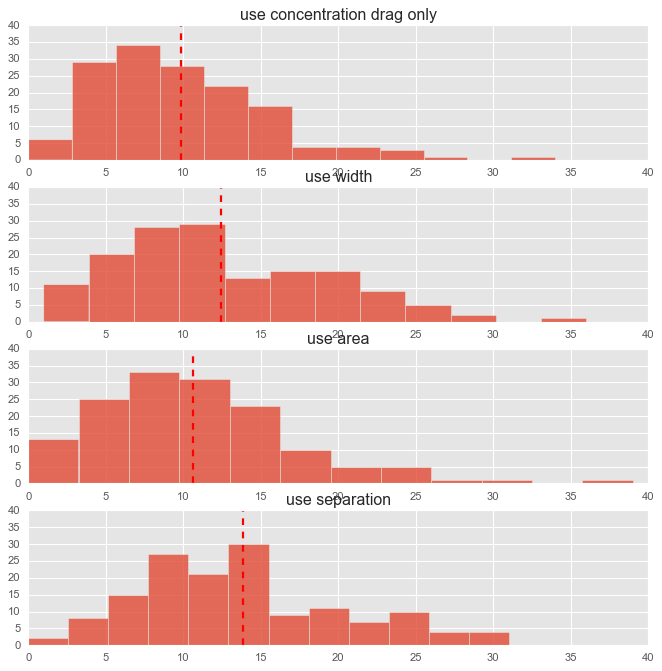

In [23]:
fig, axes = plt.subplots(4,figsize=(10,10))
plt.ylim=(0,40)
plt.xlim=(0,40)
for ax,sim_variable in zip(axes,[('L','use concentration drag only'),('L','use width'),('C','use area'),('C','use separation')]):
    sim,variable = sim_variable
    ax.hist(df[df['sim']==sim][variable], bins=12,label = variable,alpha=0.8)
    ax.axvline(df[df['sim']==sim][variable].mean(), color='r', linestyle='dashed', linewidth=2)
    ax.set_title(variable);ax.set_ylim([0,40]);ax.set_xlim([0,40])

Students on average do more individual drags of the controls for the separation variable. Let's look at how long they spend changing variable controls.

## Aggregate analysis of wiggling

In [24]:
def get_wiggle_times(df):
    df_drag = df[(df['Event']=='dragStarted')|(df['Event']=='dragEnded')]
    #this works since pairs of "dragStarted" and "dragEnded" will be consecutive
#     if df_drag[df_drag['Event']=='dragStarted'].shape[0]==df_drag[df_drag['Event']=='dragEnded'].shape[0]+1:
#         #sometimes the last dragEnded is missing, so we ignore this dragStart
#         print "dragEnded missing", set(df['User'])
#         return list(df_drag[df_drag['Event']=='dragEnded']['Time'].values - df_drag[df_drag['Event']=='dragStarted']['Time'].values[:-1])
#     else:
    return list(df_drag[df_drag['Event']=='dragEnded']['Time'].values - df_drag[df_drag['Event']=='dragStarted']['Time'].values)

In [25]:
def get_time_between_actions(df):
    df = df[df['User or Model']=='user'] #remove model events, keep only user events
    df['previous Time'] = df['Time'].shift()
    df['time difference'] = df['Time'] - df['Time'].shift()
    return df[(df['Event']!='dragging')|(df['Event']!='dragEnded')|(df['time difference']<=0)]['time difference'].values

In [59]:
def detect_aggregate_action(log_files_per_sim,students,get_use_function):
    '''
    This function is a detector for a specific action that aggregates the findings over all students.
    
    Args:
        students (list): All student to run detector on
        log_files_per_sim (dict): dictionary by sim and student of log file names
        get_use_function (function): takes a dataframe and returns what it detected

    Returns:
        aggregate_action_use (dict): a dictionary by sim by student of aggregate use of action
    '''
    aggregate_action_use = {'beers':{sid:[] for sid in students},'capacitor':{sid:[] for sid in students}}
    
    for sim in ['beers','capacitor']:
        for sid in students:
            logs = log_files_per_sim[sim][sid]
            use = []

            for log in logs:
                df = prep_parsing_data(log,remove_model_events=False)
                if not df.empty:
                    try:
                        use.extend(get_use_function(df))
                    except:
                        print "Unable to run aggregate detector on sim =",sim,", sid =",sid
            aggregate_action_use[sim][sid] = use
    
    return aggregate_action_use

In [27]:
wiggle_times = detect_aggregate_action(log_files_per_sim,students,get_wiggle_times)
#Here error means an unequal number of drag start and end

Unequal number of drag start and end for sim = beers , sid = 19470169
Unequal number of drag start and end for sim = beers , sid = 12816168
Unequal number of drag start and end for sim = beers , sid = 10866146
Unequal number of drag start and end for sim = capacitor , sid = 19618321
Unequal number of drag start and end for sim = capacitor , sid = 17691169
Unequal number of drag start and end for sim = capacitor , sid = 16901162
Unequal number of drag start and end for sim = capacitor , sid = 19053161
Unequal number of drag start and end for sim = capacitor , sid = 11394167
Unequal number of drag start and end for sim = capacitor , sid = 19436162
Unequal number of drag start and end for sim = capacitor , sid = 19989152
Unequal number of drag start and end for sim = capacitor , sid = 16233163
Unequal number of drag start and end for sim = capacitor , sid = 17576140
Unequal number of drag start and end for sim = capacitor , sid = 16317166
Unequal number of drag start and end for sim = cap

2.02436364325



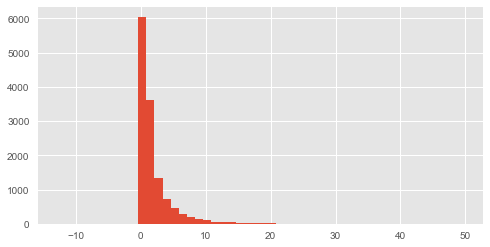

In [28]:
import itertools
from matplotlib import pyplot as plt
all_wiggle_times = list(itertools.chain.from_iterable(wiggle_times['beers'].values()+wiggle_times['capacitor'].values()))
print np.mean(all_wiggle_times)
plt.hist(all_wiggle_times,bins=50)
print

In [49]:
all_intervals = detect_aggregate_action(log_files_per_sim,students,get_time_between_actions)

d:\applications\anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\applications\anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
all_intervals = detect_aggregate_action(log_files_per_sim,[9044165],get_time_between_actions)

In [52]:
import itertools
from matplotlib import pyplot as plt
intervals = list(itertools.chain.from_iterable(all_intervals['beers'].values()+all_intervals['capacitor'].values()))
print np.mean(intervals)
# plt.hist(intervals)
print intervals[0:100]

nan
[nan, 2.891, 0.24500000000000011, 0.01699999999999946, 0.017000000000000348, 0.022999999999999687, 0.018000000000000682, 0.01499999999999968, 0.0080000000000000071, 0.013999999999999346, 0.022000000000000242, 0.017000000000000348, 0.020000000000000462, 0.021999999999999353, 0.012000000000000455, 0.01499999999999968, 0.01699999999999946, 0.023000000000000576, 0.016000000000000014, 0.0030000000000001137, 0.001000000000000334, 0.006999999999998785, 0.0070000000000014495, 0.01699999999999946, 0.11099999999999888, 0.0080000000000008953, 0.015000000000000568, 0.010999999999999233, 0.024000000000000909, 0.017999999999998906, 0.015000000000000568, 0.016000000000000014, 0.027000000000001023, 0.0019999999999988916, 0.00099999999999944578, 0.0079999999999991189, 0.011000000000001009, 0.0039999999999995595, 0.0070000000000014495, 0.0089999999999985647, 0.0070000000000014495, 0.073999999999999844, 0.27200000000000024, 0.015999999999998238, 0.0060000000000002274, 0.018000000000000682, 0.01500000